<div style='float: right'>28.11.2022</div><div style='float: left'>Daniel Müller</div>
<center> Machine Learning</center>
Student ID: -
<hr><center><h1>KNN vs. Logistic Regression and regularization on bank customer churn</h1></center><hr>

## 1. Introduction

## 2. Main Part
1. Data overview
2. Parameter description of Logistic Regression
3. Data Preprocessing
4. Estimate performance of KNN-Classifier, Logistic Regression with/without polynomial features
5. Results and discussion

## 3. Conclusion
## 4. References
<hr>

## Introduction
In times where online banks become more popular, traditional banks must defend their positions. With `Bank Customer Churn Prediction` [3] the international ABC bank offers a dataset, where customer data samples are labelled with wether a customer churns the bank or not. On this dataset we will apply KNN, Logistic Regression and polynomial Logistic Regression to find out which features of the customer lead to churn the bank and which classifier performs best.
<hr>

## Main Part

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tabulate import tabulate

### 1. Data overview
The aim is to predict the customer churn for the international ABC bank.

We have 11 features:
- `Customer ID` Kundennummer
- `Credit Score` Kreditwürdigkeit
- `Coutry` Herkunft
- `Gender` Geschlecht
- `Age` Alter
- `Tenure` Kunde seit x Jahren
- `Balance` Kontostand
- `Products Number` Nummer des Produkts
- `Credit Card` hat Kunde Kreditkarte?
- `Active Member` aktiver Kunde?
- `Estimated Salary` geschätztes Gehalt

and a binary target variable:
- `Churn`

In [3]:
data = pd.read_csv('Bank Customer Churn Prediction.csv')

In [4]:
data.head(8)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1


In [5]:
data.shape

(10000, 12)

In [5]:
print('Genders:', np.unique(data['gender']), '\nCountries:', np.unique(data['country']))

Genders: ['Female' 'Male'] 
Countries: ['France' 'Germany' 'Spain']


In [6]:
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
data.describe().round(2)

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


<hr> 

- We have 10.000 samples, 11 features and 1 binary target variable `Churn`.
- There are no missing values.
- `Customer ID` is a useless feature and must be removed.
- There are two categorical variables. `Gender` has values `Male` and `Female`. `Country` has `France`, `Germany`, `Spain`.
- The 75%-Quantile is at `Age` 44, so the very most customers are younger.
- The 25%-Quantile of `Balance` is still 0, what means there are quite a few people without any balance.
<hr>

Number of churned customers:     2037 
Number of not churned customers: 7963


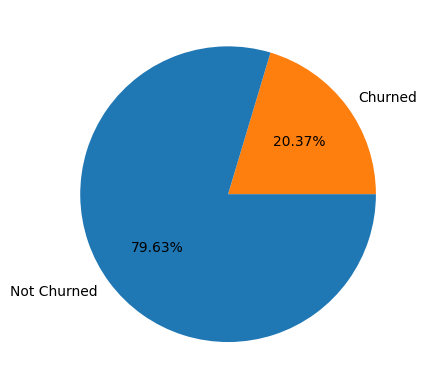

In [8]:
print('Number of churned customers:    ', data.churn[data['churn']==1].count(),
      '\nNumber of not churned customers:', data.churn[data['churn']==0].count())
plt.pie([data.churn[data['churn']==1].count(), data.churn[data['churn']==0].count()],
       labels=['Churned', 'Not Churned'], autopct='%1.2f%%', colors=['tab:orange', 'tab:blue'])
plt.show()

<hr>

- We have 7.963 samples (80%) for not churned and 2.037 (20%) for churned customers. This is an extreme imbalance in the data set.
<hr>

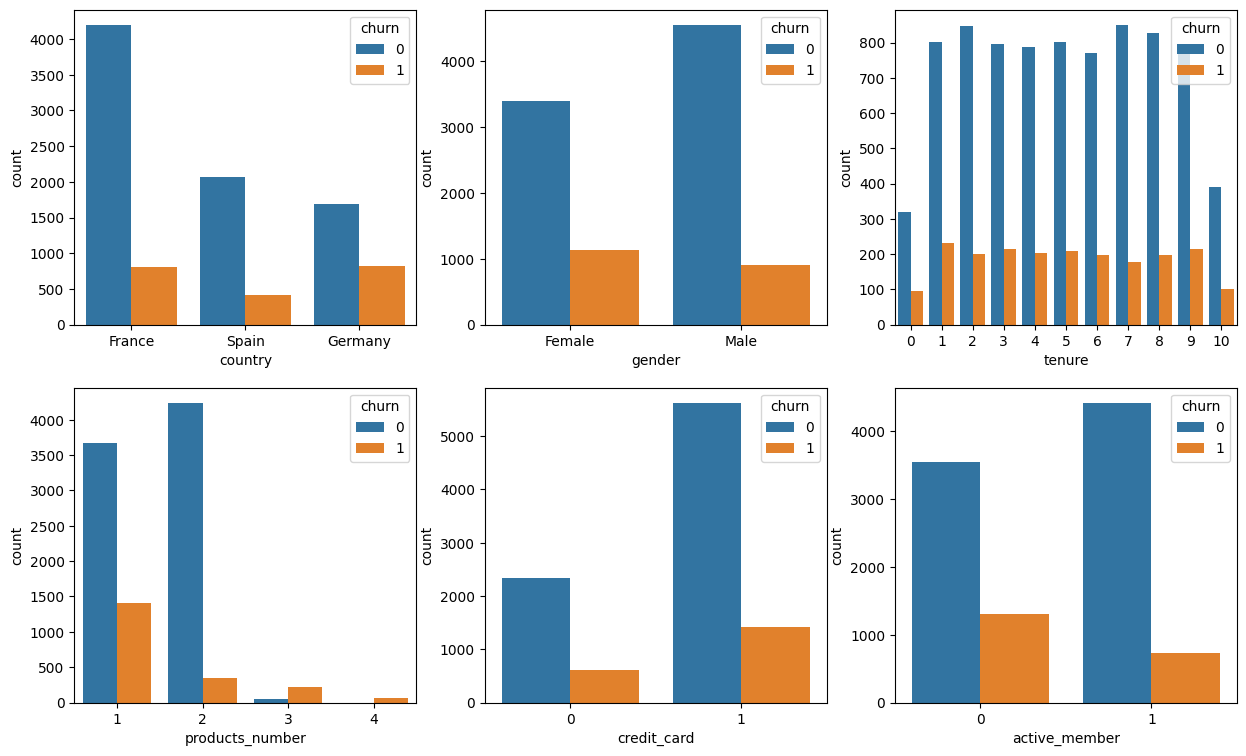

In [9]:
x = ['country', 'gender', 'tenure', 'products_number', 'credit_card', 'active_member']
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(data, x=x[i], hue='churn', ax=ax)
plt.show()

In [10]:
table = []
cols = ['country', 'country', 'country', 'gender', 'gender',
        'products_number', 'products_number', 'products_number', 'products_number',
        'credit_card', 'credit_card', 'active_member', 'active_member']
c = ['France', 'Spain', 'Germany', 'Male', 'Female', 1, 2, 3, 4, 0, 1, 0, 1]

for i in range(len(c)):
    table.append([f' {cols[i]:16}: {c[i]}',
                  data[cols[i]][(data[cols[i]]==c[i]) & (data['churn']==0)].count(),
                  (data[cols[i]][(data[cols[i]]==c[i]) & (data['churn']==0)].count() * 100 / data[cols[i]][data[cols[i]]==c[i]].count()).round(),
                  data[cols[i]][(data[cols[i]]==c[i]) & (data['churn']==1)].count(),
                  (data[cols[i]][(data[cols[i]]==c[i]) & (data['churn']==1)].count() * 100 / data[cols[i]][data[cols[i]]==c[i]].count()).round(),
                  data[cols[i]][data[cols[i]]==c[i]].count()])

print(tabulate(table, headers=['Number of customers', 'not churned', 'in %', 'churned', 'in %', 'sum']))

Number of customers          not churned    in %    churned    in %    sum
-------------------------  -------------  ------  ---------  ------  -----
country         : France            4204      84        810      16   5014
country         : Spain             2064      83        413      17   2477
country         : Germany           1695      68        814      32   2509
gender          : Male              4559      84        898      16   5457
gender          : Female            3404      75       1139      25   4543
products_number : 1                 3675      72       1409      28   5084
products_number : 2                 4242      92        348       8   4590
products_number : 3                   46      17        220      83    266
products_number : 4                    0       0         60     100     60
credit_card     : 0                 2332      79        613      21   2945
credit_card     : 1                 5631      80       1424      20   7055
active_member   : 0      

<hr>

- 50% of customers are from France. In percentage these are the most loyal to the bank. Germany is the least.
- 25% of `Gender` female and 16% of male customers churn.
- The percantage of customers who churn is for every `Tenure` roughly equal. So it seems this is not an indicator for being loyal to the bank or not.
- 83% of customers who have 3 products churn. For those who have 4 products it is 100%.
- The percentage of people who churn with and without `Credit Card` is nearly similar.
- In percentage the number of churning inactive members is twice that of `Acitve Members`.
<hr>

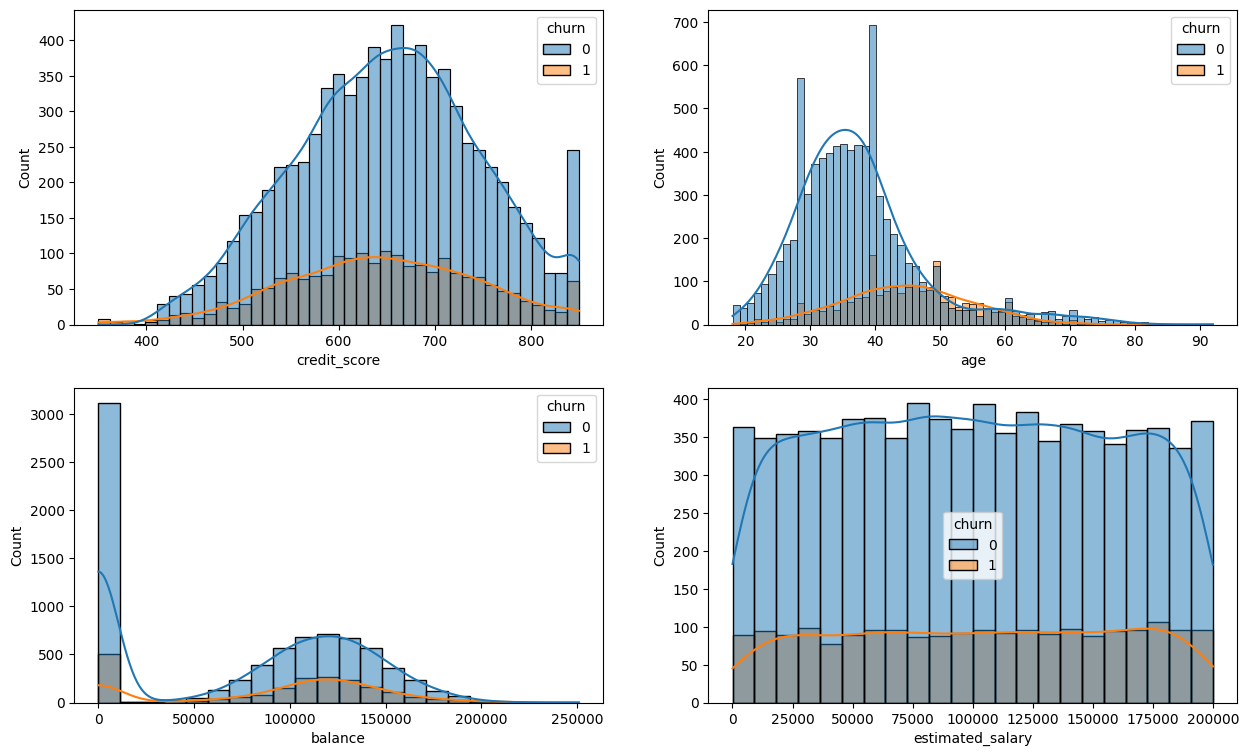

In [11]:
x = ['credit_score', 'age', 'balance', 'estimated_salary']
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(data, x=x[i], hue='churn', fill=True, ax=ax, kde=True)
plt.show()

<hr>

- `Credit Score` and `Estimated Salary` have a relatively equal distance from churned to loyal customers. That means churned customers are increasing with the increase of the sum of all customers and as well as the increase of loyal customers but not with respect to `Credit Score` or `Estimated Salary`.
- With increasing `Age` the number of churning customers is increasing too, up to the age of about 50. As said before, the 75%-Quantile is at age 44, so the very most customers are younger. Correlation can be inferred from this.
- Much customers have a `Balance` from 0.
<hr>

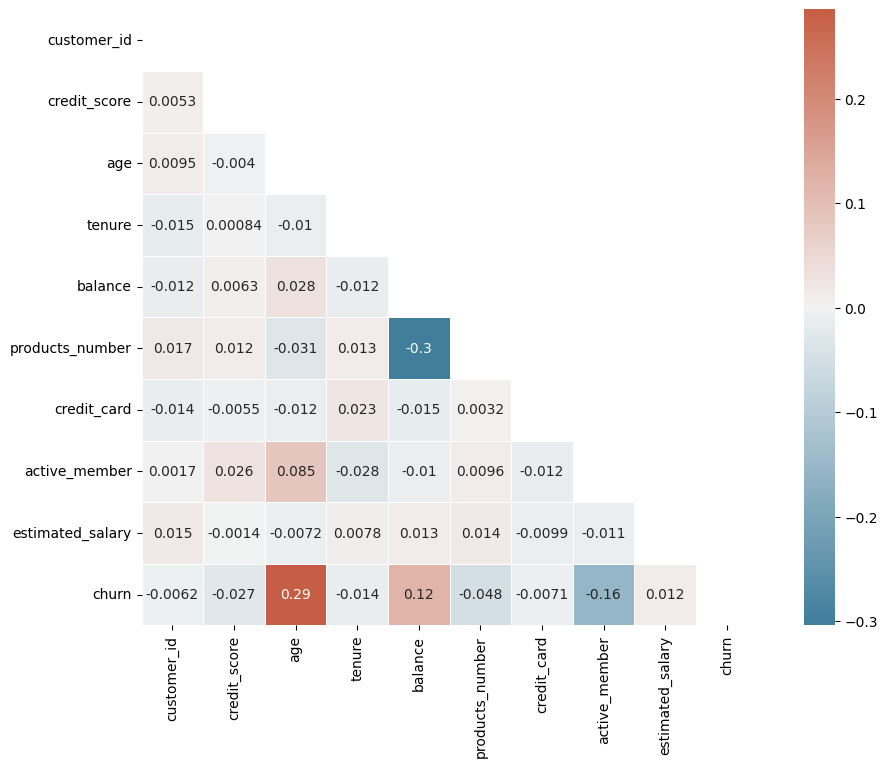

In [12]:
plt.figure(figsize=(12,8))
corr=data.corr(numeric_only=True)
mask=np.triu(np.ones_like(corr,dtype=bool))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr,cmap=cmap, annot=True, mask=mask,linewidth=0.5,square=True,center=0)
plt.show()

<hr>

- `Age` has the highest correlation with `Churn`, which means older customers tend to leave the bank more than younger.
- `Products Number` and `Balance` have a negative correlation. With increasing `Products Number` the `Balance` decreases. Maybe that's a reason why most customers churn with 3 or 4 products.
- `Balance` and `Active Member` have also a small correlation with `Churn`.

<hr>

### 2. Parameter description of Logistic Regression <br>
<center>$\underset{w}{\min}$ <span style='color:tomato'>$C$</span>$\displaystyle \sum_{(\tilde{x},\tilde{y}) \in D}(-\tilde{y} \ln (p_{w}(\tilde{x})) - (1 - \tilde{y}) \ln (1 - p_{w}(\tilde{x})))$<span style='color:tomato'> $\space+r(w)$</span></center>

#### Penalty term $r(w)$
- defines the penalty term
- None $= 0$<br style='margin-bottom: 15px'>
- $\ell_{1} = ||w||_{1}$<brlarge><br style='margin-bottom: 15px'>
- $\ell_{2} = \frac{1}{2}||w||_{2}^{2} = \frac{1}{2}w^{T}w$<br style='margin-bottom: 15px'>
- ElasticNet = $\frac{1- \rho}{2} w^{T} w + \rho ||w||_{1}$<br>
ist eine Kombination von $\ell_{1}$ und $\ell_{2}$,
wobei $\rho$ das Verhältnis zwischen $\ell_{1}$ und $\ell_{2}$ steuert
für $\rho = 1$ erhält man $\ell_{1}$<br>
für $\rho = 0$ erhält man $\ell_{2}$<br>

#### Regularization parameter C
- $C = \frac{1}{\lambda}$
- is the inverted parameter for regularization
- smaller values effect higher penalty
- C musst be strictly positive

<hr>

### 3. Data Preprocessing
#### Seperate target variables

In [6]:
X = data.iloc[:,:-1]
y = data['churn']

#### Remove useless features
The `customer_id` is useless because there is no crucial structure behind it.

In [7]:
X.drop('customer_id', axis=1, inplace=True)
X

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


#### How to treat categorical variables?
There are different ways to make the categorical variables understandable for the PC like One-Hot-Encoding or Lable-Encoding. Since no `Country` or `Gender` is more important than an other, no weighting may be included. Therefore we use One-Hot-Encoding to get numerical features. This gives us two more features for `Country` and one more for `Gender`.

In [8]:
transformed = make_column_transformer((OneHotEncoder(), ['country', 'gender']), remainder='passthrough',
                                     verbose_feature_names_out=False).fit_transform(X)
X = pd.DataFrame(transformed)
X.columns = ['france', 'germany', 'spain', 'female', 'male', 'credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
X_columns = X.columns
X

,france,germany,spain,female,male,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,1.0,0.0,0.0,1.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88
1,0.0,0.0,1.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58
2,1.0,0.0,0.0,1.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57
3,1.0,0.0,0.0,1.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63
4,0.0,0.0,1.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64
9996,1.0,0.0,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77
9997,1.0,0.0,0.0,1.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58
9998,0.0,1.0,0.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52


#### Scale data
Because the dataset has some features with high variance like `Credit Score` or `Estimated Salary` we scale the data to make them look like standard normally distributed. This is also a good idea when working with models that use a linear distance like KNN.

[...] it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set [...] [2, p. 70].

<hr>

### 4. Estimate performance of KNN-Classifier, Logistic Regression with/without polynomial features

In [9]:
# 5-fold nested cv
X = np.array(X)
y = np.array(y)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_solver = 'liblinear'

#### KNN

In [17]:
param = {'knn__n_neighbors': np.arange(1,51)}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

knn_grid = GridSearchCV(pipe, param, cv=inner_cv, scoring='accuracy', n_jobs=-1)
knn_score = cross_validate(knn_grid, X, y, cv=outer_cv, return_estimator=True)
knn_score_ = np.mean(knn_score['test_score'])
knn_time_ = sum(knn_score['fit_time'])

**Best k in each outer CV**

In [18]:
outer_ks = [['best k']]
for e in knn_score['estimator']:
    outer_ks[0].append(e.best_params_['knn__n_neighbors'])

print(tabulate(outer_ks, headers=['cv1', 'cv2', 'cv3', 'cv4', 'cv5']))

          cv1    cv2    cv3    cv4    cv5
------  -----  -----  -----  -----  -----
best k     13     19     13     15     15


#### Logistic Regression

In [12]:
param = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lr', LogisticRegression(solver=lr_solver))])

lr_grid = GridSearchCV(pipe, param, cv=inner_cv, scoring='accuracy', n_jobs=-1)
lr_score = cross_validate(lr_grid, X, y, cv=outer_cv, return_estimator=True)
lr_score_ =  np.mean(lr_score['test_score'])
lr_time_ = sum(lr_score['fit_time'])

**Best C for each outer CV**

In [20]:
outer_cs = [['best c']]
for e in lr_score['estimator']:
    outer_cs[0].append(e.best_params_['lr__C'])

print(tabulate(outer_cs, headers=['cv1', 'cv2', 'cv3', 'cv4', 'cv5']))

          cv1    cv2    cv3    cv4    cv5
------  -----  -----  -----  -----  -----
best c   0.01   0.01      1      1   0.01


**Weights for each outer CV**

In [21]:
outer_coefficients = []
for i, feature in enumerate(X_columns):
    coef_per_feature = [feature]
    for e in lr_score['estimator']:
        coef_per_feature.append(e.best_estimator_.named_steps['lr'].coef_[0][i].round(3))    
    outer_coefficients.append(coef_per_feature)
    outer_coefficients[i].append(np.mean(outer_coefficients[i][1:]).round(3))
    outer_coefficients[i].append(np.var(outer_coefficients[i][1:]).round(4))
    
print(tabulate(sorted(outer_coefficients, key=lambda outer_coefficients: outer_coefficients[5], reverse=True),
               headers=['weights cv1', 'weights cv2', 'weights cv3', 'weights cv4', 'weights cv5', 'mean', 'var']))

                    weights cv1    weights cv2    weights cv3    weights cv4    weights cv5    mean     var
----------------  -------------  -------------  -------------  -------------  -------------  ------  ------
age                       0.645          0.642          0.766          0.77           0.653   0.695  0.003
germany                   0.202          0.215          0.218          0.242          0.206   0.217  0.0002
balance                   0.138          0.16           0.177          0.127          0.143   0.149  0.0003
female                    0.117          0.108          0.139          0.131          0.118   0.123  0.0001
estimated_salary          0.014          0.019          0.055          0.014          0.026   0.026  0.0002
tenure                   -0.035         -0.062         -0.059         -0.031         -0.017  -0.041  0.0002
credit_card              -0.008         -0.036          0.015         -0.025         -0.031  -0.017  0.0003
credit_score             -0.0

<hr>

- `Age`, which has the highest correlation with `Churn`, is now also the highest weighted feature.
- Followed by Germany, where 32% churn and `Balance` which also had a correlation of 0,12.
- The highest negative correlation has `Active Member`, where 27% leave the bank.
- The two `Genders` have an opposite correlation.
<hr>

#### Logistic Regression with polynomial features

Number of features per degree:
1. 14
2. 105
3. 560
4. 2.380
5. 8.568 (kernel down)
6. 27.132 > 10.000 samples

In [22]:
param = {'poly__degree': [1, 2, 3, 4], 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('poly', PolynomialFeatures()),
                 ('lr', LogisticRegression(solver=lr_solver))])

lrp_grid = GridSearchCV(pipe, param, cv=inner_cv, scoring='accuracy', n_jobs=-1)
lrp_score = cross_validate(lrp_grid, X, y, cv=outer_cv, return_estimator=True)
lrp_score_ = np.mean(lrp_score['test_score'])
lrp_time_ = sum(lrp_score['fit_time'])

**Best C and degree of each outer CV**

In [23]:
outer_pcs = [['best C'], ['best degree']]
for e in lrp_score['estimator']:
    outer_pcs[0].append(e.best_params_['lr__C'])
    outer_pcs[1].append(e.best_params_['poly__degree'])

print(tabulate(outer_pcs, headers=['cv1', 'cv2', 'cv3', 'cv4', 'cv5']))

               cv1    cv2    cv3    cv4    cv5
-----------  -----  -----  -----  -----  -----
best C       0.001  0.001  0.001  0.001   0.01
best degree  3      4      4      4       3


<hr>

- For higher degrees of the polynom we have much more features.
- Thus a higher penalty term is needed to avoid overfitting.
<hr>

### 5. Results and discussion

#### Accuracies and computing time

In [25]:
accuracies = [['KNN', f'{knn_score_:.4f}', f'{knn_time_:.2f}'],
              ['Logistic Regression', f'{lr_score_:.4f}', f'{lr_time_:.2f}'],
              ['Polynomial Logistic Regression', f'{lrp_score_:.4f}', f'{lrp_time_:.2f}']]
print(tabulate(accuracies, headers=['classifier', 'accuracy', 'computing time']))

classifier                        accuracy    computing time
------------------------------  ----------  ----------------
KNN                                 0.8318             67.79
Logistic Regression                 0.8098              1.08
Polynomial Logistic Regression      0.86             4023.22


#### KNN
- KNN performs with an accuracy of 0.83 better than Logistic Regression with 0.81, therefore we can make the assumption, that a non-linear decision boundary is needed here. In return, it has a higher computing time.
- Note that for a very large k, KNN always predicts a customer does't `Churn`, because 80% of the samples is from that class.
- For a small k, KNN can get a ragged decision boundary or can form islands what yields a bad generalization.
- KNN gives us a model that is not well interpretable.

#### Logistic Regression
- Standard Logistic Regression computes much faster than KNN Classification, but has a lower accuracy in this case.
- The linear decision boundary of Logistic Regression performs bad on this data set.
- Logistic Regression gives us a table of coefficents what makes the model gut interpretable.

#### Polynomial Logistic Regressoin
- The GridSearch of polynomial Logistic Regression chose for the hyperparameter C very small values which means a higher penalty. The reason for this is that the number of features increases extremely with higher polynom degrees. With the penalty term we can avoid overfitting.
- With Polynomial Regression and its transformed features we can get a non-linear but smooth decision boundary.
- This one performs best on the bank churn data set with an accuracy of 0.86.

<hr>

# Conclusion

- The accuracy of KNN depends strongly on its hyperparameter k.
- When k is too small, the train score is 1 and we get high variance and an overfitting.
- When k is too large, the model has small complexity and we get high bias and an underfitting.
- Unlike logistic regression, KNN does not tell us which predictors are important: we don't get a table of **coefficients** [...] [1, p. 161].
- In order to provide accurate classification, KNN requires a lot of **observations** relative to the number of predictors  [...]. This has to do with the fact that KNN is non-parametric, and thus tends to reduce the bias while incurring a lot of variance [1, p. 161].


- Logistic Regression has a linear decision boundary. This can be changed by applying polynomial features. Then the boundary gets non-linear.
- The regularization of Logistic Regression avoids overfitting. Thus its more easy to use polynomial regression which give us an increasing number of features.

The bank should check the following to stem customer churn:
- What's going better in France than in Germany?
- What's going wrong when a customer has 3 or 4 products?
- Why do older people churn more than younger?

# References
[1] James, G. et al. (no date) *An introduction to statistical learning, SpringerLink.* Springer US. Available at: https://link.springer.com/book/10.1007/978-1-0716-1418-1

[2] Aurélien Géron, *Hands-on machine learning with Scikit-Learn and TensorFlow concepts, tools, and techniques to build intelligent systems.* O’Reilly Media, Inc., 2019.

[3] Unknown Author, *Customer Churn Prediction.* Available at: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset